<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[10:04:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


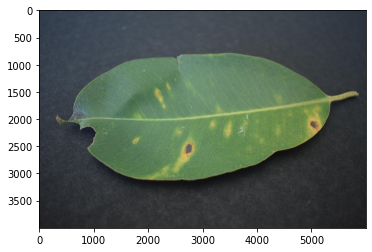

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

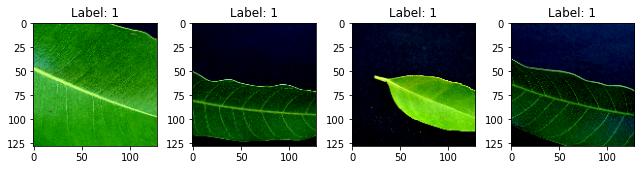

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[10:04:15] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[10:04:17] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.265727443661067 samples/sec                   batch loss = 0.4930754005908966 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.2737350141428547 samples/sec                   batch loss = 0.7886276841163635 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2414718633426205 samples/sec                   batch loss = 0.3810763955116272 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2700160837362595 samples/sec                   batch loss = 0.6749338507652283 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.269833158014802 samples/sec                   batch loss = 0.6387735605239868 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.2739040727731017 samples/sec                   batch loss = 1.2532689571380615 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.2775732619093507 samples/sec                   batch loss = 0.6681920886039734 | accuracy = 0.55


Epoch[1] Batch[40] Speed: 1.2740735633025366 samples/sec                   batch loss = 0.6159527897834778 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2803259618938323 samples/sec                   batch loss = 1.8085991144180298 | accuracy = 0.5555555555555556


Epoch[1] Batch[50] Speed: 1.279602760037949 samples/sec                   batch loss = 0.7776584625244141 | accuracy = 0.55


Epoch[1] Batch[55] Speed: 1.2771506927065943 samples/sec                   batch loss = 0.4008758068084717 | accuracy = 0.5636363636363636


Epoch[1] Batch[60] Speed: 1.2751667568602891 samples/sec                   batch loss = 0.604285478591919 | accuracy = 0.5708333333333333


Epoch[1] Batch[65] Speed: 1.2752532154939638 samples/sec                   batch loss = 0.5724327564239502 | accuracy = 0.5653846153846154


Epoch[1] Batch[70] Speed: 1.2765975449649196 samples/sec                   batch loss = 0.7270088791847229 | accuracy = 0.5714285714285714


Epoch[1] Batch[75] Speed: 1.2785213390366779 samples/sec                   batch loss = 0.4379032254219055 | accuracy = 0.57


Epoch[1] Batch[80] Speed: 1.2833191313593355 samples/sec                   batch loss = 0.74018794298172 | accuracy = 0.571875


Epoch[1] Batch[85] Speed: 1.2731405705299186 samples/sec                   batch loss = 0.9400162696838379 | accuracy = 0.5764705882352941


Epoch[1] Batch[90] Speed: 1.2773924322572727 samples/sec                   batch loss = 0.8326299786567688 | accuracy = 0.5833333333333334


Epoch[1] Batch[95] Speed: 1.2774273491108339 samples/sec                   batch loss = 0.8250628709793091 | accuracy = 0.5842105263157895


Epoch[1] Batch[100] Speed: 1.281505871080504 samples/sec                   batch loss = 1.2161071300506592 | accuracy = 0.5875


Epoch[1] Batch[105] Speed: 1.2752633935707698 samples/sec                   batch loss = 1.0198204517364502 | accuracy = 0.5857142857142857


Epoch[1] Batch[110] Speed: 1.2770033212162804 samples/sec                   batch loss = 0.2411140352487564 | accuracy = 0.5977272727272728


Epoch[1] Batch[115] Speed: 1.2837339074315584 samples/sec                   batch loss = 0.6111483573913574 | accuracy = 0.6


Epoch[1] Batch[120] Speed: 1.2817151858795415 samples/sec                   batch loss = 0.5370203256607056 | accuracy = 0.6020833333333333


Epoch[1] Batch[125] Speed: 1.2814934396584154 samples/sec                   batch loss = 1.0355205535888672 | accuracy = 0.604


Epoch[1] Batch[130] Speed: 1.2740193833436773 samples/sec                   batch loss = 0.700607180595398 | accuracy = 0.6076923076923076


Epoch[1] Batch[135] Speed: 1.2757970492107453 samples/sec                   batch loss = 0.6744053363800049 | accuracy = 0.6111111111111112


Epoch[1] Batch[140] Speed: 1.27865307899005 samples/sec                   batch loss = 0.4938686490058899 | accuracy = 0.6178571428571429


Epoch[1] Batch[145] Speed: 1.2771767487245524 samples/sec                   batch loss = 0.42870432138442993 | accuracy = 0.6224137931034482


Epoch[1] Batch[150] Speed: 1.2765113895808278 samples/sec                   batch loss = 0.6059536933898926 | accuracy = 0.6233333333333333


Epoch[1] Batch[155] Speed: 1.2728224088512101 samples/sec                   batch loss = 0.860579788684845 | accuracy = 0.6225806451612903


Epoch[1] Batch[160] Speed: 1.2796174971501286 samples/sec                   batch loss = 0.669308066368103 | accuracy = 0.628125


Epoch[1] Batch[165] Speed: 1.2775711216141128 samples/sec                   batch loss = 0.5397446751594543 | accuracy = 0.6318181818181818


Epoch[1] Batch[170] Speed: 1.2805468155308934 samples/sec                   batch loss = 0.3281998634338379 | accuracy = 0.6323529411764706


Epoch[1] Batch[175] Speed: 1.2767172299131369 samples/sec                   batch loss = 0.47017422318458557 | accuracy = 0.6285714285714286


Epoch[1] Batch[180] Speed: 1.2747435501557298 samples/sec                   batch loss = 0.897913932800293 | accuracy = 0.6263888888888889


Epoch[1] Batch[185] Speed: 1.2765217820035952 samples/sec                   batch loss = 0.4682094156742096 | accuracy = 0.6283783783783784


Epoch[1] Batch[190] Speed: 1.2769216788324167 samples/sec                   batch loss = 0.16295035183429718 | accuracy = 0.6328947368421053


Epoch[1] Batch[195] Speed: 1.2732979715684125 samples/sec                   batch loss = 0.44868218898773193 | accuracy = 0.6346153846153846


Epoch[1] Batch[200] Speed: 1.2752815206432255 samples/sec                   batch loss = 0.5876376032829285 | accuracy = 0.6375


Epoch[1] Batch[205] Speed: 1.2749600596944466 samples/sec                   batch loss = 0.8982471227645874 | accuracy = 0.6365853658536585


Epoch[1] Batch[210] Speed: 1.2761051493454312 samples/sec                   batch loss = 0.3263041079044342 | accuracy = 0.638095238095238


Epoch[1] Batch[215] Speed: 1.278780557389312 samples/sec                   batch loss = 0.6352333426475525 | accuracy = 0.6372093023255814


Epoch[1] Batch[220] Speed: 1.2828153584748756 samples/sec                   batch loss = 0.8781387805938721 | accuracy = 0.6352272727272728


Epoch[1] Batch[225] Speed: 1.2760951519504982 samples/sec                   batch loss = 0.34272849559783936 | accuracy = 0.6366666666666667


Epoch[1] Batch[230] Speed: 1.2824177417615257 samples/sec                   batch loss = 0.41102635860443115 | accuracy = 0.6347826086956522


Epoch[1] Batch[235] Speed: 1.2745464790204692 samples/sec                   batch loss = 0.4350256621837616 | accuracy = 0.6361702127659574


Epoch[1] Batch[240] Speed: 1.2848877336425337 samples/sec                   batch loss = 0.34644991159439087 | accuracy = 0.6375


Epoch[1] Batch[245] Speed: 1.2747916893192492 samples/sec                   batch loss = 0.48274433612823486 | accuracy = 0.6377551020408163


Epoch[1] Batch[250] Speed: 1.2782644657567896 samples/sec                   batch loss = 0.5885802507400513 | accuracy = 0.64


Epoch[1] Batch[255] Speed: 1.2843876450496479 samples/sec                   batch loss = 0.9237778186798096 | accuracy = 0.6421568627450981


Epoch[1] Batch[260] Speed: 1.2835886463887722 samples/sec                   batch loss = 0.7379134297370911 | accuracy = 0.6432692307692308


Epoch[1] Batch[265] Speed: 1.279821606897293 samples/sec                   batch loss = 0.5851372480392456 | accuracy = 0.6433962264150943


Epoch[1] Batch[270] Speed: 1.2897273695811988 samples/sec                   batch loss = 0.6387838125228882 | accuracy = 0.6407407407407407


Epoch[1] Batch[275] Speed: 1.2767188815669568 samples/sec                   batch loss = 0.4659900367259979 | accuracy = 0.6445454545454545


Epoch[1] Batch[280] Speed: 1.2764348599405242 samples/sec                   batch loss = 0.4808085262775421 | accuracy = 0.6455357142857143


Epoch[1] Batch[285] Speed: 1.2807749806496835 samples/sec                   batch loss = 0.4793648421764374 | accuracy = 0.6491228070175439


Epoch[1] Batch[290] Speed: 1.2837309606334206 samples/sec                   batch loss = 0.4007943868637085 | accuracy = 0.6491379310344828


Epoch[1] Batch[295] Speed: 1.2779943585239535 samples/sec                   batch loss = 0.2965647280216217 | accuracy = 0.652542372881356


Epoch[1] Batch[300] Speed: 1.2795301529978653 samples/sec                   batch loss = 0.644726574420929 | accuracy = 0.655


Epoch[1] Batch[305] Speed: 1.2761102936970683 samples/sec                   batch loss = 0.5412397384643555 | accuracy = 0.6549180327868852


Epoch[1] Batch[310] Speed: 1.2755068434162737 samples/sec                   batch loss = 0.6933719515800476 | accuracy = 0.6548387096774193


Epoch[1] Batch[315] Speed: 1.2753603357779768 samples/sec                   batch loss = 0.5677933096885681 | accuracy = 0.653968253968254


Epoch[1] Batch[320] Speed: 1.2798888768354921 samples/sec                   batch loss = 0.6548876762390137 | accuracy = 0.65546875


Epoch[1] Batch[325] Speed: 1.280083501540666 samples/sec                   batch loss = 0.5723267197608948 | accuracy = 0.6546153846153846


Epoch[1] Batch[330] Speed: 1.2801376124493364 samples/sec                   batch loss = 1.3776252269744873 | accuracy = 0.6522727272727272


Epoch[1] Batch[335] Speed: 1.2755663869129197 samples/sec                   batch loss = 0.3708914518356323 | accuracy = 0.6537313432835821


Epoch[1] Batch[340] Speed: 1.2676050868260906 samples/sec                   batch loss = 0.6936673521995544 | accuracy = 0.6544117647058824


Epoch[1] Batch[345] Speed: 1.2674409512854006 samples/sec                   batch loss = 1.0930485725402832 | accuracy = 0.6550724637681159


Epoch[1] Batch[350] Speed: 1.2628031324520947 samples/sec                   batch loss = 0.6676030158996582 | accuracy = 0.6557142857142857


Epoch[1] Batch[355] Speed: 1.272300307844631 samples/sec                   batch loss = 0.4414171576499939 | accuracy = 0.6549295774647887


Epoch[1] Batch[360] Speed: 1.26782157324377 samples/sec                   batch loss = 0.4208112955093384 | accuracy = 0.6555555555555556


Epoch[1] Batch[365] Speed: 1.2760206132060692 samples/sec                   batch loss = 0.4350479543209076 | accuracy = 0.6541095890410958


Epoch[1] Batch[370] Speed: 1.2697795303003927 samples/sec                   batch loss = 0.6765738129615784 | accuracy = 0.654054054054054


Epoch[1] Batch[375] Speed: 1.2685918486631829 samples/sec                   batch loss = 0.2876521050930023 | accuracy = 0.6546666666666666


Epoch[1] Batch[380] Speed: 1.278502145466173 samples/sec                   batch loss = 0.1900433599948883 | accuracy = 0.6552631578947369


Epoch[1] Batch[385] Speed: 1.2808360926520332 samples/sec                   batch loss = 0.5217295289039612 | accuracy = 0.6564935064935065


Epoch[1] Batch[390] Speed: 1.2838453063229083 samples/sec                   batch loss = 0.4554942846298218 | accuracy = 0.6576923076923077


Epoch[1] Batch[395] Speed: 1.2763228984610226 samples/sec                   batch loss = 0.5648150444030762 | accuracy = 0.6582278481012658


Epoch[1] Batch[400] Speed: 1.278383197154295 samples/sec                   batch loss = 0.6010987758636475 | accuracy = 0.656875


Epoch[1] Batch[405] Speed: 1.2778658688454416 samples/sec                   batch loss = 0.7306264638900757 | accuracy = 0.6567901234567901


Epoch[1] Batch[410] Speed: 1.277255798298958 samples/sec                   batch loss = 0.9953498244285583 | accuracy = 0.6567073170731708


Epoch[1] Batch[415] Speed: 1.2813031809009239 samples/sec                   batch loss = 0.6008777618408203 | accuracy = 0.6566265060240963


Epoch[1] Batch[420] Speed: 1.2744992297419941 samples/sec                   batch loss = 0.721077024936676 | accuracy = 0.656547619047619


Epoch[1] Batch[425] Speed: 1.2789115708486316 samples/sec                   batch loss = 0.33096858859062195 | accuracy = 0.6576470588235294


Epoch[1] Batch[430] Speed: 1.275972478228054 samples/sec                   batch loss = 0.4091170132160187 | accuracy = 0.6563953488372093


Epoch[1] Batch[435] Speed: 1.2780821746664932 samples/sec                   batch loss = 0.7485870122909546 | accuracy = 0.6580459770114943


Epoch[1] Batch[440] Speed: 1.272328868017278 samples/sec                   batch loss = 0.38257086277008057 | accuracy = 0.6607954545454545


Epoch[1] Batch[445] Speed: 1.2655066125018406 samples/sec                   batch loss = 1.5381473302841187 | accuracy = 0.6623595505617977


Epoch[1] Batch[450] Speed: 1.2690231703235297 samples/sec                   batch loss = 0.6632664799690247 | accuracy = 0.6627777777777778


Epoch[1] Batch[455] Speed: 1.2669785552084254 samples/sec                   batch loss = 0.4563286304473877 | accuracy = 0.6637362637362637


Epoch[1] Batch[460] Speed: 1.2750161607376684 samples/sec                   batch loss = 0.22627019882202148 | accuracy = 0.6652173913043479


Epoch[1] Batch[465] Speed: 1.269709186833519 samples/sec                   batch loss = 0.7489054799079895 | accuracy = 0.6645161290322581


Epoch[1] Batch[470] Speed: 1.2729969241172487 samples/sec                   batch loss = 0.37529394030570984 | accuracy = 0.6643617021276595


Epoch[1] Batch[475] Speed: 1.2674677616544605 samples/sec                   batch loss = 0.44010430574417114 | accuracy = 0.6636842105263158


Epoch[1] Batch[480] Speed: 1.2745334076605332 samples/sec                   batch loss = 0.2095528542995453 | accuracy = 0.6635416666666667


Epoch[1] Batch[485] Speed: 1.2725198488772245 samples/sec                   batch loss = 0.413849800825119 | accuracy = 0.6649484536082474


Epoch[1] Batch[490] Speed: 1.2759034846234583 samples/sec                   batch loss = 0.6129953265190125 | accuracy = 0.6663265306122449


Epoch[1] Batch[495] Speed: 1.2678709156710817 samples/sec                   batch loss = 0.5166724920272827 | accuracy = 0.6671717171717172


Epoch[1] Batch[500] Speed: 1.2693898563308577 samples/sec                   batch loss = 0.8537284731864929 | accuracy = 0.6695


Epoch[1] Batch[505] Speed: 1.2753957233552762 samples/sec                   batch loss = 0.31535524129867554 | accuracy = 0.6707920792079208


Epoch[1] Batch[510] Speed: 1.2664790185166859 samples/sec                   batch loss = 0.336048424243927 | accuracy = 0.6700980392156862


Epoch[1] Batch[515] Speed: 1.271691779293483 samples/sec                   batch loss = 0.3434056043624878 | accuracy = 0.6718446601941748


Epoch[1] Batch[520] Speed: 1.2691398070708415 samples/sec                   batch loss = 0.9139137268066406 | accuracy = 0.6701923076923076


Epoch[1] Batch[525] Speed: 1.2678019331520232 samples/sec                   batch loss = 0.372768759727478 | accuracy = 0.6695238095238095


Epoch[1] Batch[530] Speed: 1.2668573409537605 samples/sec                   batch loss = 0.4656618535518646 | accuracy = 0.6707547169811321


Epoch[1] Batch[535] Speed: 1.2656197394608546 samples/sec                   batch loss = 0.7466765642166138 | accuracy = 0.6714953271028037


Epoch[1] Batch[540] Speed: 1.2690683825180196 samples/sec                   batch loss = 0.6738998889923096 | accuracy = 0.6717592592592593


Epoch[1] Batch[545] Speed: 1.2687411228210594 samples/sec                   batch loss = 0.5518324375152588 | accuracy = 0.6738532110091743


Epoch[1] Batch[550] Speed: 1.2724608789870926 samples/sec                   batch loss = 0.9135205745697021 | accuracy = 0.6736363636363636


Epoch[1] Batch[555] Speed: 1.2709047388978503 samples/sec                   batch loss = 0.13991370797157288 | accuracy = 0.6761261261261261


Epoch[1] Batch[560] Speed: 1.272243287821982 samples/sec                   batch loss = 0.7540476322174072 | accuracy = 0.6763392857142857


Epoch[1] Batch[565] Speed: 1.2664294019800642 samples/sec                   batch loss = 0.8454341292381287 | accuracy = 0.6765486725663716


Epoch[1] Batch[570] Speed: 1.2698615114147174 samples/sec                   batch loss = 0.5123239159584045 | accuracy = 0.6776315789473685


Epoch[1] Batch[575] Speed: 1.2723427626189492 samples/sec                   batch loss = 0.5066822171211243 | accuracy = 0.678695652173913


Epoch[1] Batch[580] Speed: 1.2690541753667026 samples/sec                   batch loss = 0.9691362977027893 | accuracy = 0.6788793103448276


Epoch[1] Batch[585] Speed: 1.2688328536732454 samples/sec                   batch loss = 0.4880898594856262 | accuracy = 0.6786324786324787


Epoch[1] Batch[590] Speed: 1.2729141513651994 samples/sec                   batch loss = 0.7422880530357361 | accuracy = 0.6779661016949152


Epoch[1] Batch[595] Speed: 1.2769279960251876 samples/sec                   batch loss = 0.6583889126777649 | accuracy = 0.6781512605042017


Epoch[1] Batch[600] Speed: 1.2712443857631857 samples/sec                   batch loss = 0.6538571715354919 | accuracy = 0.6791666666666667


Epoch[1] Batch[605] Speed: 1.2691406711267443 samples/sec                   batch loss = 0.23483973741531372 | accuracy = 0.6809917355371901


Epoch[1] Batch[610] Speed: 1.2718191267095937 samples/sec                   batch loss = 0.4324086308479309 | accuracy = 0.6819672131147541


Epoch[1] Batch[615] Speed: 1.269688815590915 samples/sec                   batch loss = 0.3375336229801178 | accuracy = 0.6829268292682927


Epoch[1] Batch[620] Speed: 1.2682661768945847 samples/sec                   batch loss = 0.7495357394218445 | accuracy = 0.6830645161290323


Epoch[1] Batch[625] Speed: 1.2715140561238487 samples/sec                   batch loss = 0.37267181277275085 | accuracy = 0.6852


Epoch[1] Batch[630] Speed: 1.2724369451409796 samples/sec                   batch loss = 0.12280313670635223 | accuracy = 0.6865079365079365


Epoch[1] Batch[635] Speed: 1.2732381565218105 samples/sec                   batch loss = 0.5858118534088135 | accuracy = 0.6874015748031496


Epoch[1] Batch[640] Speed: 1.2723774039542617 samples/sec                   batch loss = 0.8573107719421387 | accuracy = 0.687890625


Epoch[1] Batch[645] Speed: 1.2733091814754531 samples/sec                   batch loss = 1.32460618019104 | accuracy = 0.6872093023255814


Epoch[1] Batch[650] Speed: 1.271706334747274 samples/sec                   batch loss = 2.4332282543182373 | accuracy = 0.6865384615384615


Epoch[1] Batch[655] Speed: 1.2702336830412169 samples/sec                   batch loss = 0.5770464539527893 | accuracy = 0.6870229007633588


Epoch[1] Batch[660] Speed: 1.2720727406669299 samples/sec                   batch loss = 0.9915058016777039 | accuracy = 0.6882575757575757


Epoch[1] Batch[665] Speed: 1.2726782549671893 samples/sec                   batch loss = 0.5957499742507935 | accuracy = 0.6890977443609022


Epoch[1] Batch[670] Speed: 1.2700659817164937 samples/sec                   batch loss = 0.30879276990890503 | accuracy = 0.6902985074626866


Epoch[1] Batch[675] Speed: 1.268494302207448 samples/sec                   batch loss = 0.5387818813323975 | accuracy = 0.6896296296296296


Epoch[1] Batch[680] Speed: 1.269587737773158 samples/sec                   batch loss = 0.4743344783782959 | accuracy = 0.6904411764705882


Epoch[1] Batch[685] Speed: 1.269997817633326 samples/sec                   batch loss = 0.22091864049434662 | accuracy = 0.6905109489051094


Epoch[1] Batch[690] Speed: 1.2714171196304973 samples/sec                   batch loss = 0.6585656404495239 | accuracy = 0.6909420289855073


Epoch[1] Batch[695] Speed: 1.2723123685719457 samples/sec                   batch loss = 0.3212055265903473 | accuracy = 0.6920863309352518


Epoch[1] Batch[700] Speed: 1.2729353023047747 samples/sec                   batch loss = 0.8761234283447266 | accuracy = 0.6917857142857143


Epoch[1] Batch[705] Speed: 1.2678885457414169 samples/sec                   batch loss = 0.3467749059200287 | accuracy = 0.6921985815602837


Epoch[1] Batch[710] Speed: 1.2789341889842014 samples/sec                   batch loss = 0.715251088142395 | accuracy = 0.6911971830985916


Epoch[1] Batch[715] Speed: 1.2657874145819519 samples/sec                   batch loss = 1.087190866470337 | accuracy = 0.691958041958042


Epoch[1] Batch[720] Speed: 1.2722759941134958 samples/sec                   batch loss = 0.24371735751628876 | accuracy = 0.6920138888888889


Epoch[1] Batch[725] Speed: 1.2734433291237452 samples/sec                   batch loss = 0.367481529712677 | accuracy = 0.6931034482758621


Epoch[1] Batch[730] Speed: 1.2750184862760774 samples/sec                   batch loss = 0.5170426368713379 | accuracy = 0.6934931506849316


Epoch[1] Batch[735] Speed: 1.275070716227572 samples/sec                   batch loss = 0.6197333335876465 | accuracy = 0.6928571428571428


Epoch[1] Batch[740] Speed: 1.279621498676272 samples/sec                   batch loss = 0.4542670249938965 | accuracy = 0.6929054054054054


Epoch[1] Batch[745] Speed: 1.2736924664076192 samples/sec                   batch loss = 0.37094494700431824 | accuracy = 0.6929530201342282


Epoch[1] Batch[750] Speed: 1.2769655117192444 samples/sec                   batch loss = 0.1348797082901001 | accuracy = 0.692


Epoch[1] Batch[755] Speed: 1.2731507149115544 samples/sec                   batch loss = 0.44954144954681396 | accuracy = 0.6907284768211921


Epoch[1] Batch[760] Speed: 1.2742707785605354 samples/sec                   batch loss = 0.9380291104316711 | accuracy = 0.6914473684210526


Epoch[1] Batch[765] Speed: 1.275796758162861 samples/sec                   batch loss = 0.5315598845481873 | accuracy = 0.6908496732026144


Epoch[1] Batch[770] Speed: 1.2793918906037551 samples/sec                   batch loss = 0.5274788737297058 | accuracy = 0.6909090909090909


Epoch[1] Batch[775] Speed: 1.2786988825228724 samples/sec                   batch loss = 0.7205051183700562 | accuracy = 0.6903225806451613


Epoch[1] Batch[780] Speed: 1.2800292975455676 samples/sec                   batch loss = 0.6272135972976685 | accuracy = 0.6900641025641026


Epoch[1] Batch[785] Speed: 1.2738622875180339 samples/sec                   batch loss = 0.5325431823730469 | accuracy = 0.6904458598726114


[Epoch 1] training: accuracy=0.6897208121827412
[Epoch 1] time cost: 646.3240919113159
[Epoch 1] validation: validation accuracy=0.7655555555555555


Epoch[2] Batch[5] Speed: 1.2659181670688648 samples/sec                   batch loss = 0.5174532532691956 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2724440865975903 samples/sec                   batch loss = 0.727235734462738 | accuracy = 0.6


Epoch[2] Batch[15] Speed: 1.2780960004802415 samples/sec                   batch loss = 0.5147346258163452 | accuracy = 0.6


Epoch[2] Batch[20] Speed: 1.2732004730292075 samples/sec                   batch loss = 0.31777817010879517 | accuracy = 0.6


Epoch[2] Batch[25] Speed: 1.2732960388457681 samples/sec                   batch loss = 0.4479154050350189 | accuracy = 0.64


Epoch[2] Batch[30] Speed: 1.2730793212223013 samples/sec                   batch loss = 0.3611534535884857 | accuracy = 0.675


Epoch[2] Batch[35] Speed: 1.2718037009867817 samples/sec                   batch loss = 0.6848635077476501 | accuracy = 0.6928571428571428


Epoch[2] Batch[40] Speed: 1.2698692006905663 samples/sec                   batch loss = 0.40096554160118103 | accuracy = 0.7125


Epoch[2] Batch[45] Speed: 1.2678978400519516 samples/sec                   batch loss = 0.5951480269432068 | accuracy = 0.7111111111111111


Epoch[2] Batch[50] Speed: 1.2728681818840497 samples/sec                   batch loss = 0.1063976064324379 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.2706436991894856 samples/sec                   batch loss = 0.6630127429962158 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.2701562695300952 samples/sec                   batch loss = 0.8543084263801575 | accuracy = 0.7083333333333334


Epoch[2] Batch[65] Speed: 1.270192138219837 samples/sec                   batch loss = 0.41532665491104126 | accuracy = 0.7076923076923077


Epoch[2] Batch[70] Speed: 1.2746954146277716 samples/sec                   batch loss = 0.5377298593521118 | accuracy = 0.7071428571428572


Epoch[2] Batch[75] Speed: 1.269273269647306 samples/sec                   batch loss = 0.3917825222015381 | accuracy = 0.71


Epoch[2] Batch[80] Speed: 1.275084476964072 samples/sec                   batch loss = 0.48769956827163696 | accuracy = 0.71875


Epoch[2] Batch[85] Speed: 1.2719295279600278 samples/sec                   batch loss = 0.3520488142967224 | accuracy = 0.7176470588235294


Epoch[2] Batch[90] Speed: 1.2683580308550937 samples/sec                   batch loss = 0.39542627334594727 | accuracy = 0.7138888888888889


Epoch[2] Batch[95] Speed: 1.2709504703865233 samples/sec                   batch loss = 0.5751054286956787 | accuracy = 0.7131578947368421


Epoch[2] Batch[100] Speed: 1.2728612288062457 samples/sec                   batch loss = 0.34553107619285583 | accuracy = 0.7225


Epoch[2] Batch[105] Speed: 1.2737282449948333 samples/sec                   batch loss = 0.8269362449645996 | accuracy = 0.7261904761904762


Epoch[2] Batch[110] Speed: 1.2693186917311197 samples/sec                   batch loss = 1.4451652765274048 | accuracy = 0.7204545454545455


Epoch[2] Batch[115] Speed: 1.2743078479095908 samples/sec                   batch loss = 0.21505869925022125 | accuracy = 0.7195652173913043


Epoch[2] Batch[120] Speed: 1.2758572019565375 samples/sec                   batch loss = 0.7780811190605164 | accuracy = 0.7125


Epoch[2] Batch[125] Speed: 1.2691594886359983 samples/sec                   batch loss = 0.39357277750968933 | accuracy = 0.712


Epoch[2] Batch[130] Speed: 1.273193612941072 samples/sec                   batch loss = 0.8538972735404968 | accuracy = 0.7134615384615385


Epoch[2] Batch[135] Speed: 1.272144793190606 samples/sec                   batch loss = 0.3808463215827942 | accuracy = 0.7129629629629629


Epoch[2] Batch[140] Speed: 1.276865604338106 samples/sec                   batch loss = 0.5468333959579468 | accuracy = 0.7160714285714286


Epoch[2] Batch[145] Speed: 1.2721745039705559 samples/sec                   batch loss = 0.12466074526309967 | accuracy = 0.7206896551724138


Epoch[2] Batch[150] Speed: 1.2691447034031809 samples/sec                   batch loss = 0.6083090901374817 | accuracy = 0.7183333333333334


Epoch[2] Batch[155] Speed: 1.2680482926917385 samples/sec                   batch loss = 0.7606983780860901 | accuracy = 0.7225806451612903


Epoch[2] Batch[160] Speed: 1.2674921792274478 samples/sec                   batch loss = 0.1821369230747223 | accuracy = 0.725


Epoch[2] Batch[165] Speed: 1.2705298647918268 samples/sec                   batch loss = 0.4365527629852295 | accuracy = 0.7242424242424242


Epoch[2] Batch[170] Speed: 1.2708215641637326 samples/sec                   batch loss = 0.5998111367225647 | accuracy = 0.7279411764705882


Epoch[2] Batch[175] Speed: 1.2713904309645097 samples/sec                   batch loss = 0.9248416423797607 | accuracy = 0.7214285714285714


Epoch[2] Batch[180] Speed: 1.2718482437811425 samples/sec                   batch loss = 0.26846837997436523 | accuracy = 0.7236111111111111


Epoch[2] Batch[185] Speed: 1.2749239212224643 samples/sec                   batch loss = 0.44792231917381287 | accuracy = 0.722972972972973


Epoch[2] Batch[190] Speed: 1.2696254959493511 samples/sec                   batch loss = 0.48683953285217285 | accuracy = 0.7223684210526315


Epoch[2] Batch[195] Speed: 1.2676265405861562 samples/sec                   batch loss = 0.34808704257011414 | accuracy = 0.7243589743589743


Epoch[2] Batch[200] Speed: 1.2737203155129424 samples/sec                   batch loss = 0.24036386609077454 | accuracy = 0.725


Epoch[2] Batch[205] Speed: 1.2764215555967744 samples/sec                   batch loss = 0.2668444812297821 | accuracy = 0.724390243902439


Epoch[2] Batch[210] Speed: 1.269094109790772 samples/sec                   batch loss = 0.734176754951477 | accuracy = 0.725


Epoch[2] Batch[215] Speed: 1.269273269647306 samples/sec                   batch loss = 0.32028916478157043 | accuracy = 0.727906976744186


Epoch[2] Batch[220] Speed: 1.2730989319522699 samples/sec                   batch loss = 0.3057180643081665 | accuracy = 0.7238636363636364


Epoch[2] Batch[225] Speed: 1.2699142809434774 samples/sec                   batch loss = 0.44404447078704834 | accuracy = 0.7255555555555555


Epoch[2] Batch[230] Speed: 1.2717848049862843 samples/sec                   batch loss = 0.41632476449012756 | accuracy = 0.725


Epoch[2] Batch[235] Speed: 1.2684789570314239 samples/sec                   batch loss = 0.8340733647346497 | accuracy = 0.723404255319149


Epoch[2] Batch[240] Speed: 1.2750727512473543 samples/sec                   batch loss = 0.2588649392127991 | accuracy = 0.7270833333333333


Epoch[2] Batch[245] Speed: 1.2699678239093477 samples/sec                   batch loss = 0.4364122152328491 | accuracy = 0.7244897959183674


Epoch[2] Batch[250] Speed: 1.2763101790150895 samples/sec                   batch loss = 0.26143914461135864 | accuracy = 0.728


Epoch[2] Batch[255] Speed: 1.2757767731924403 samples/sec                   batch loss = 0.39943453669548035 | accuracy = 0.7294117647058823


Epoch[2] Batch[260] Speed: 1.2767343295948792 samples/sec                   batch loss = 0.8673046827316284 | accuracy = 0.7307692307692307


Epoch[2] Batch[265] Speed: 1.274775319658504 samples/sec                   batch loss = 0.2226083129644394 | accuracy = 0.7339622641509433


Epoch[2] Batch[270] Speed: 1.2736654887481298 samples/sec                   batch loss = 0.3669412434101105 | accuracy = 0.737037037037037


Epoch[2] Batch[275] Speed: 1.2790731325826057 samples/sec                   batch loss = 0.19205376505851746 | accuracy = 0.7381818181818182


Epoch[2] Batch[280] Speed: 1.271450168881603 samples/sec                   batch loss = 0.37209659814834595 | accuracy = 0.7383928571428572


Epoch[2] Batch[285] Speed: 1.2744457880591353 samples/sec                   batch loss = 0.38316047191619873 | accuracy = 0.7421052631578947


Epoch[2] Batch[290] Speed: 1.2729168555557284 samples/sec                   batch loss = 0.6929144263267517 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.2727536589205213 samples/sec                   batch loss = 0.468345582485199 | accuracy = 0.7406779661016949


Epoch[2] Batch[300] Speed: 1.2704095092679561 samples/sec                   batch loss = 0.5075260400772095 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.278812528436005 samples/sec                   batch loss = 0.23451003432273865 | accuracy = 0.7442622950819672


Epoch[2] Batch[310] Speed: 1.2737824001936349 samples/sec                   batch loss = 0.09694749116897583 | accuracy = 0.7443548387096774


Epoch[2] Batch[315] Speed: 1.2739657884183975 samples/sec                   batch loss = 1.4900368452072144 | accuracy = 0.7452380952380953


Epoch[2] Batch[320] Speed: 1.2816511506141106 samples/sec                   batch loss = 0.664766252040863 | accuracy = 0.7453125


Epoch[2] Batch[325] Speed: 1.2788222760243309 samples/sec                   batch loss = 0.2627624571323395 | accuracy = 0.7476923076923077


Epoch[2] Batch[330] Speed: 1.27798472090177 samples/sec                   batch loss = 1.3639805316925049 | accuracy = 0.7462121212121212


Epoch[2] Batch[335] Speed: 1.2732039514119997 samples/sec                   batch loss = 0.500368058681488 | accuracy = 0.7455223880597015


Epoch[2] Batch[340] Speed: 1.2683898664386108 samples/sec                   batch loss = 0.23465360701084137 | accuracy = 0.7455882352941177


Epoch[2] Batch[345] Speed: 1.2688270961166692 samples/sec                   batch loss = 0.39047467708587646 | accuracy = 0.7434782608695653


Epoch[2] Batch[350] Speed: 1.272391589112224 samples/sec                   batch loss = 0.08155018091201782 | accuracy = 0.745


Epoch[2] Batch[355] Speed: 1.2749835071983546 samples/sec                   batch loss = 0.7280159592628479 | accuracy = 0.745774647887324


Epoch[2] Batch[360] Speed: 1.2735246239803186 samples/sec                   batch loss = 0.25052547454833984 | accuracy = 0.7451388888888889


Epoch[2] Batch[365] Speed: 1.2731472368196393 samples/sec                   batch loss = 0.3922596573829651 | accuracy = 0.7472602739726028


Epoch[2] Batch[370] Speed: 1.274141391496072 samples/sec                   batch loss = 0.11093559861183167 | accuracy = 0.7472972972972973


Epoch[2] Batch[375] Speed: 1.2693346334445283 samples/sec                   batch loss = 0.1061667650938034 | accuracy = 0.748


Epoch[2] Batch[380] Speed: 1.2717457614579202 samples/sec                   batch loss = 0.24585509300231934 | accuracy = 0.75


Epoch[2] Batch[385] Speed: 1.2737225396259493 samples/sec                   batch loss = 0.4874154031276703 | accuracy = 0.75


Epoch[2] Batch[390] Speed: 1.26441409363809 samples/sec                   batch loss = 0.44896435737609863 | accuracy = 0.7506410256410256


Epoch[2] Batch[395] Speed: 1.276460206939557 samples/sec                   batch loss = 0.5850239992141724 | accuracy = 0.7487341772151899


Epoch[2] Batch[400] Speed: 1.2689504152115374 samples/sec                   batch loss = 0.47417187690734863 | accuracy = 0.748125


Epoch[2] Batch[405] Speed: 1.2694152124482048 samples/sec                   batch loss = 0.4385957717895508 | accuracy = 0.75


Epoch[2] Batch[410] Speed: 1.2724993873468755 samples/sec                   batch loss = 0.22654594480991364 | accuracy = 0.751219512195122


Epoch[2] Batch[415] Speed: 1.271308637664502 samples/sec                   batch loss = 0.13636364042758942 | accuracy = 0.7536144578313253


Epoch[2] Batch[420] Speed: 1.270815884804678 samples/sec                   batch loss = 1.0314748287200928 | accuracy = 0.7547619047619047


Epoch[2] Batch[425] Speed: 1.2774050760227826 samples/sec                   batch loss = 0.43521058559417725 | accuracy = 0.7552941176470588


Epoch[2] Batch[430] Speed: 1.2681605325283487 samples/sec                   batch loss = 0.5932867527008057 | accuracy = 0.7546511627906977


Epoch[2] Batch[435] Speed: 1.2715505797694262 samples/sec                   batch loss = 0.993593692779541 | accuracy = 0.7557471264367817


Epoch[2] Batch[440] Speed: 1.2720543189088664 samples/sec                   batch loss = 0.23354916274547577 | accuracy = 0.7539772727272728


Epoch[2] Batch[445] Speed: 1.2723673683872843 samples/sec                   batch loss = 1.7074629068374634 | accuracy = 0.7539325842696629


Epoch[2] Batch[450] Speed: 1.2706551511160407 samples/sec                   batch loss = 1.0712199211120605 | accuracy = 0.7533333333333333


Epoch[2] Batch[455] Speed: 1.2700658855701796 samples/sec                   batch loss = 0.5414444208145142 | accuracy = 0.7521978021978022


Epoch[2] Batch[460] Speed: 1.272517049855449 samples/sec                   batch loss = 0.6431207656860352 | accuracy = 0.7527173913043478


Epoch[2] Batch[465] Speed: 1.2719155459557252 samples/sec                   batch loss = 0.5300908088684082 | accuracy = 0.7526881720430108


Epoch[2] Batch[470] Speed: 1.2679708578293982 samples/sec                   batch loss = 0.20430028438568115 | accuracy = 0.7542553191489362


Epoch[2] Batch[475] Speed: 1.267738705770075 samples/sec                   batch loss = 0.44941797852516174 | accuracy = 0.7552631578947369


Epoch[2] Batch[480] Speed: 1.2732992278412776 samples/sec                   batch loss = 0.47228074073791504 | accuracy = 0.7546875


Epoch[2] Batch[485] Speed: 1.270746485212131 samples/sec                   batch loss = 1.162392258644104 | accuracy = 0.7536082474226804


Epoch[2] Batch[490] Speed: 1.265258186044179 samples/sec                   batch loss = 1.5101544857025146 | accuracy = 0.753061224489796


Epoch[2] Batch[495] Speed: 1.2667861730676286 samples/sec                   batch loss = 0.3757391571998596 | accuracy = 0.7535353535353535


Epoch[2] Batch[500] Speed: 1.2696763241145186 samples/sec                   batch loss = 0.5546006560325623 | accuracy = 0.754


Epoch[2] Batch[505] Speed: 1.273108012987553 samples/sec                   batch loss = 0.4655143916606903 | accuracy = 0.7534653465346535


Epoch[2] Batch[510] Speed: 1.263608432694568 samples/sec                   batch loss = 0.460615873336792 | accuracy = 0.7524509803921569


Epoch[2] Batch[515] Speed: 1.2696262645869492 samples/sec                   batch loss = 0.21221184730529785 | accuracy = 0.7509708737864078


Epoch[2] Batch[520] Speed: 1.264500339240791 samples/sec                   batch loss = 0.47390761971473694 | accuracy = 0.7504807692307692


Epoch[2] Batch[525] Speed: 1.268365318377747 samples/sec                   batch loss = 0.37375885248184204 | accuracy = 0.7509523809523809


Epoch[2] Batch[530] Speed: 1.269523659698186 samples/sec                   batch loss = 0.167924702167511 | accuracy = 0.7514150943396226


Epoch[2] Batch[535] Speed: 1.2679183455076464 samples/sec                   batch loss = 0.8601731061935425 | accuracy = 0.752803738317757


Epoch[2] Batch[540] Speed: 1.2723917821097512 samples/sec                   batch loss = 0.4777764081954956 | accuracy = 0.7518518518518519


Epoch[2] Batch[545] Speed: 1.2718103532838543 samples/sec                   batch loss = 0.6358133554458618 | accuracy = 0.7522935779816514


Epoch[2] Batch[550] Speed: 1.2673249137671925 samples/sec                   batch loss = 0.4230245053768158 | accuracy = 0.7518181818181818


Epoch[2] Batch[555] Speed: 1.27663270980504 samples/sec                   batch loss = 0.38543859124183655 | accuracy = 0.7504504504504504


Epoch[2] Batch[560] Speed: 1.2646740097270925 samples/sec                   batch loss = 0.5090510845184326 | accuracy = 0.7517857142857143


Epoch[2] Batch[565] Speed: 1.269310624992576 samples/sec                   batch loss = 1.2817139625549316 | accuracy = 0.7504424778761062


Epoch[2] Batch[570] Speed: 1.2712115398487143 samples/sec                   batch loss = 0.5080680251121521 | accuracy = 0.749561403508772


Epoch[2] Batch[575] Speed: 1.2694471011246837 samples/sec                   batch loss = 0.6415114998817444 | accuracy = 0.7491304347826087


Epoch[2] Batch[580] Speed: 1.2707293530535588 samples/sec                   batch loss = 0.24358132481575012 | accuracy = 0.7491379310344828


Epoch[2] Batch[585] Speed: 1.272529500770888 samples/sec                   batch loss = 0.44588857889175415 | accuracy = 0.7487179487179487


Epoch[2] Batch[590] Speed: 1.278908646148135 samples/sec                   batch loss = 0.478208988904953 | accuracy = 0.747457627118644


Epoch[2] Batch[595] Speed: 1.2683440313754806 samples/sec                   batch loss = 0.3560470640659332 | accuracy = 0.7474789915966387


Epoch[2] Batch[600] Speed: 1.2760154695774586 samples/sec                   batch loss = 0.2976394593715668 | accuracy = 0.7470833333333333


Epoch[2] Batch[605] Speed: 1.2749708144342133 samples/sec                   batch loss = 0.5879148244857788 | accuracy = 0.7471074380165289


Epoch[2] Batch[610] Speed: 1.2753900999925805 samples/sec                   batch loss = 0.26288777589797974 | accuracy = 0.7475409836065574


Epoch[2] Batch[615] Speed: 1.2700370423332408 samples/sec                   batch loss = 0.5299039483070374 | accuracy = 0.7479674796747967


Epoch[2] Batch[620] Speed: 1.2789552479675301 samples/sec                   batch loss = 0.5813969969749451 | accuracy = 0.7483870967741936


Epoch[2] Batch[625] Speed: 1.2742958461087879 samples/sec                   batch loss = 2.599212408065796 | accuracy = 0.748


Epoch[2] Batch[630] Speed: 1.2682029032001056 samples/sec                   batch loss = 0.38333821296691895 | accuracy = 0.7476190476190476


Epoch[2] Batch[635] Speed: 1.275636507962456 samples/sec                   batch loss = 0.37328729033470154 | accuracy = 0.7488188976377953


Epoch[2] Batch[640] Speed: 1.2743884787710364 samples/sec                   batch loss = 0.447358101606369 | accuracy = 0.749609375


Epoch[2] Batch[645] Speed: 1.2743849939130043 samples/sec                   batch loss = 0.34980344772338867 | accuracy = 0.7507751937984496


Epoch[2] Batch[650] Speed: 1.2680709115896802 samples/sec                   batch loss = 0.7921584248542786 | accuracy = 0.7503846153846154


Epoch[2] Batch[655] Speed: 1.2709122482638338 samples/sec                   batch loss = 0.196971595287323 | accuracy = 0.750381679389313


Epoch[2] Batch[660] Speed: 1.2716554403102385 samples/sec                   batch loss = 0.5221181511878967 | accuracy = 0.7507575757575757


Epoch[2] Batch[665] Speed: 1.2689694190400447 samples/sec                   batch loss = 0.44643452763557434 | accuracy = 0.750375939849624


Epoch[2] Batch[670] Speed: 1.2718849794720999 samples/sec                   batch loss = 0.19378496706485748 | accuracy = 0.7511194029850746


Epoch[2] Batch[675] Speed: 1.2740099023246338 samples/sec                   batch loss = 0.35087260603904724 | accuracy = 0.7507407407407407


Epoch[2] Batch[680] Speed: 1.2717185770094253 samples/sec                   batch loss = 0.5949661731719971 | accuracy = 0.7503676470588235


Epoch[2] Batch[685] Speed: 1.2660982466610173 samples/sec                   batch loss = 0.35220032930374146 | accuracy = 0.75


Epoch[2] Batch[690] Speed: 1.2761284448540025 samples/sec                   batch loss = 0.5044829845428467 | accuracy = 0.7507246376811594


Epoch[2] Batch[695] Speed: 1.2716995871444856 samples/sec                   batch loss = 0.23944637179374695 | accuracy = 0.7510791366906475


Epoch[2] Batch[700] Speed: 1.274546575846358 samples/sec                   batch loss = 0.4472126066684723 | accuracy = 0.7510714285714286


Epoch[2] Batch[705] Speed: 1.2720988792602101 samples/sec                   batch loss = 0.5184969902038574 | accuracy = 0.7514184397163121


Epoch[2] Batch[710] Speed: 1.2714667423307338 samples/sec                   batch loss = 0.6334677934646606 | accuracy = 0.7510563380281691


Epoch[2] Batch[715] Speed: 1.2687830525376205 samples/sec                   batch loss = 0.41290831565856934 | accuracy = 0.7520979020979021


Epoch[2] Batch[720] Speed: 1.270683637475755 samples/sec                   batch loss = 0.5626498460769653 | accuracy = 0.7524305555555556


Epoch[2] Batch[725] Speed: 1.2757790044930386 samples/sec                   batch loss = 0.646769642829895 | accuracy = 0.7520689655172413


Epoch[2] Batch[730] Speed: 1.276131550986074 samples/sec                   batch loss = 0.4324071407318115 | accuracy = 0.7523972602739726


Epoch[2] Batch[735] Speed: 1.2745082339449507 samples/sec                   batch loss = 0.19302929937839508 | accuracy = 0.7537414965986394


Epoch[2] Batch[740] Speed: 1.2753551974711241 samples/sec                   batch loss = 0.4348229765892029 | accuracy = 0.7543918918918919


Epoch[2] Batch[745] Speed: 1.27227705540776 samples/sec                   batch loss = 0.37226417660713196 | accuracy = 0.7543624161073825


Epoch[2] Batch[750] Speed: 1.2647824111491806 samples/sec                   batch loss = 0.29023444652557373 | accuracy = 0.7543333333333333


Epoch[2] Batch[755] Speed: 1.2684654344028015 samples/sec                   batch loss = 0.4132430851459503 | accuracy = 0.7546357615894039


Epoch[2] Batch[760] Speed: 1.2733835004199143 samples/sec                   batch loss = 0.15407374501228333 | accuracy = 0.7552631578947369


Epoch[2] Batch[765] Speed: 1.2677042207652371 samples/sec                   batch loss = 0.4023113548755646 | accuracy = 0.7552287581699346


Epoch[2] Batch[770] Speed: 1.274599735480466 samples/sec                   batch loss = 0.18792873620986938 | accuracy = 0.7561688311688312


Epoch[2] Batch[775] Speed: 1.2706810390048688 samples/sec                   batch loss = 0.19808292388916016 | accuracy = 0.7564516129032258


Epoch[2] Batch[780] Speed: 1.2724583697513001 samples/sec                   batch loss = 1.1013100147247314 | accuracy = 0.7567307692307692


Epoch[2] Batch[785] Speed: 1.2747285376794557 samples/sec                   batch loss = 1.425832748413086 | accuracy = 0.7560509554140128


[Epoch 2] training: accuracy=0.7553934010152284
[Epoch 2] time cost: 637.2938251495361
[Epoch 2] validation: validation accuracy=0.8


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7888888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)